# Anomaly_Detection on a small dataset

### Dataset used: https://www.kaggle.com/datasets/roumaissaa/ucf-crime-anomaly-videos-part-1-no-abuse

#### Environment Setup
This cell installs the `ultralytics` library, which provides access to YOLO models (like YOLOv8) for object detection and tracking. It's a foundational step to ensure all necessary computer vision tools are available.

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install "numpy<2.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 96.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
jaxlib 0.7.2 req

Recently, NumPy 2.0 was released, which introduced breaking changes. It appears your Kaggle environment has NumPy 2.x installed (possibly pulled in by ultralytics or another dependency), but the installed version of scipy (or tensorflow) is compiled expecting NumPy 1.x.

In [3]:
# importing all necesary libraries

import os
import json
import random
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from ultralytics import YOLO
from tqdm import tqdm

print("Importing Libraries Successfull!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Importing Libraries Successfull!


#### Data Preprocessing and Loading
This cell defines functions to preprocess video data. `extract_sequence` samples a fixed number of frames from a video, resizing them for model input. `load_dataset` then uses this to load videos from the downloaded dataset, assign labels (normal or anomaly based on folder structure), and prepare them for training by splitting into training and testing sets. This step transforms raw video files into numerical data suitable for a neural network.

In [4]:
# --- SECTION 2: DATA PROCESSING ---

IMG_SIZE = 128
SEQ_LENGTH = 20
BATCH_SIZE = 10
EPOCHS = 20 # Kept low for demonstration speed; increase to 20+ for better results
MAX_VIDEOS = 150 # Setting to 150 as requested by the user

def extract_sequence(video_path):
    """Extracts exactly SEQ_LENGTH frames from video"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(int(total_frames / SEQ_LENGTH), 1)

    for i in range(SEQ_LENGTH):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame / 255.0
            frames.append(frame)
        else:
            break
    cap.release()

    # Padding
    while len(frames) < SEQ_LENGTH:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3)))
    return np.array(frames)

def load_dataset(root_dir):
    X, y = [], []
    video_paths = []

    # Recursively find videos
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.mp4', '.avi', '.mpg')):
                video_paths.append(os.path.join(root, file))

    random.shuffle(video_paths)
    video_paths = video_paths[:MAX_VIDEOS]

    print(f"[-] Processing {len(video_paths)} videos for training...")

    for path in tqdm(video_paths):
        try:
            seq = extract_sequence(path)
            # Labeling Logic:
            # In this dataset, folders usually indicate class.
            # We treat "Normal" as 0, everything else (Burglary, Fighting, etc.) as 1.
            label = 0 if "Normal" in path else 1
            X.append(seq)
            y.append(label)
        except Exception as e:
            continue

    return np.array(X), np.array(y)

X, y = load_dataset('/kaggle/input/ucf-crime-anomaly-videos-part-1-no-abuse')

# Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[-] Processing 150 videos for training...


100%|██████████| 150/150 [01:50<00:00,  1.36it/s]


#### Model Definition and Training
This cell constructs a CNN-LSTM (Convolutional Neural Network - Long Short-Term Memory) model. MobileNetV2 acts as a feature extractor (CNN) for individual frames, and the LSTM layer processes these features sequentially to learn temporal patterns, crucial for anomaly detection in videos. The model is then compiled and trained on the preprocessed data, learning to distinguish between normal and anomalous video sequences.

In [5]:
# --- SECTION 3: MODEL ARCHITECTURE (CNN-LSTM) ---
# This architecture is ideal for "Behavior" detection

def create_model():
    cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    cnn.trainable = False

    model = Sequential([
        TimeDistributed(cnn, input_shape=(SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3)),
        TimeDistributed(GlobalAveragePooling2D()),
        TimeDistributed(Flatten()),

        LSTM(64, return_sequences=False, dropout=0.2), # Captures temporal changes (movement patterns)
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

model = create_model()
optimizer = Adam(learning_rate=1e-4)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print("[-] Training Anomaly Detector...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[lr_scheduler])

model.save('/kaggle/working/anomaly_detector.h5')

I0000 00:00:1766738566.239928      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766738566.243897      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[-] Training Anomaly Detector...
Epoch 1/20


I0000 00:00:1766738634.514690     730 cuda_dnn.cc:529] Loaded cuDNN version 91002


12/12 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8438 - loss: 0.5043 - val_accuracy: 0.9667 - val_loss: 0.2523 - learning_rate: 1.0000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.9943 - loss: 0.2162 - val_accuracy: 0.9667 - val_loss: 0.1689 - learning_rate: 1.0000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.9755 - loss: 0.1390 - val_accuracy: 0.9667 - val_loss: 0.1546 - learning_rate: 1.0000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.9964 - loss: 0.0578 - val_accuracy: 0.9667 - val_loss: 0.1551 - learning_rate: 1.0000e-04
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9825 - loss: 0.0920
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.9832 - loss: 0.0896 - val_accuracy: 0.9667 - val_loss: 0.1578 - learning_rate: 1.0000e-04
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.9987 - loss: 0.0

#### Training Visualization
This cell visualizes the training progress of the anomaly detection model. It plots the training and validation accuracy and loss over epochs, allowing for an assessment of the model's learning performance and to identify potential overfitting or underfitting issues.

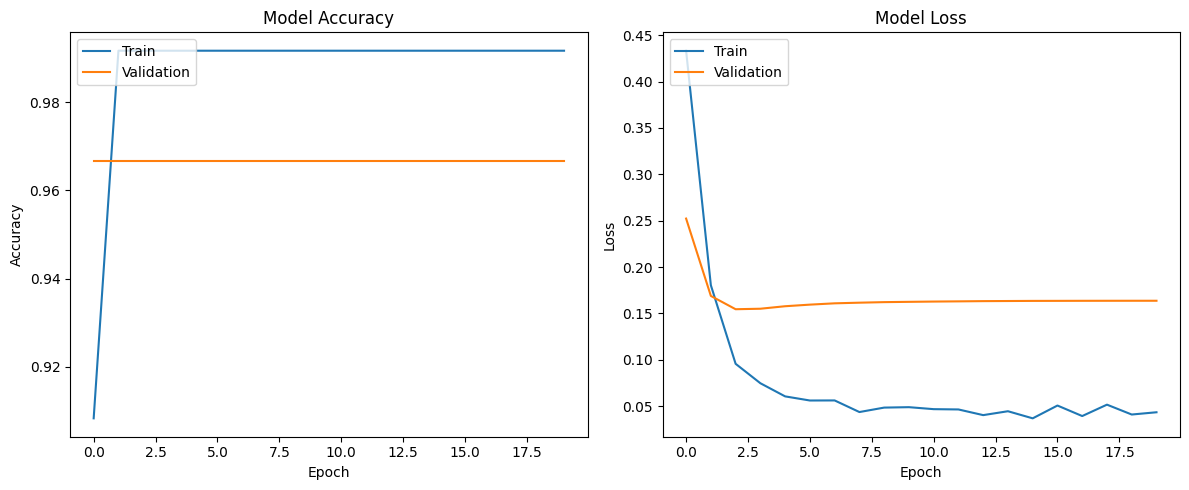

In [6]:
import matplotlib.pyplot as plt

# Assuming 'history' object is available from the model training
# If not, you may need to re-run your model.fit() command and assign its output to 'history'

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    print("Accuracy data not found in history. Ensure 'history' object contains accuracy metrics.")


# Plot training & validation loss values
plt.subplot(1, 2, 2)
if 'loss' in history.history and 'val_loss' in history.history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
else:
    print("Loss data not found in history. Ensure 'history' object contains loss metrics.")

plt.tight_layout()
plt.show()

In [7]:
# --- SECTION 4: INFERENCE WITH FILTERED YOLOv8 ---

def process_suspicious_activity(video_path, anomaly_model, yolo_model):
    """
    1. Detect Anomaly Score.
    2. If Suspicious: Track Persons (Assault/Fighting) and Bags (Theft).
    """
    # 1. Prediction Step
    print(f"[-] Analyzing: {os.path.basename(video_path)}")
    seq = extract_sequence(video_path)
    score = anomaly_model.predict(np.expand_dims(seq, axis=0))[0][0]

    is_anomaly = score > 0.5
    label_text = f"ANOMALY ({score:.2f})" if is_anomaly else f"NORMAL ({score:.2f})"
    color = (0, 0, 255) if is_anomaly else (0, 255, 0)

    # 2. Visualization Step
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    out_path = "/kaggle/working/output_filtered_tracking.mp4"
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    trajectories = {}

    # FILTER CLASSES:
    # 0: Person (Assault/Fighting/Burglary)
    # 24: Backpack, 26: Handbag (Shoplifting/Theft)
    TARGET_CLASSES = [0, 24, 26]

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        cv2.putText(frame, f"Status: {label_text}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        if is_anomaly:
            # Run YOLO only on specific classes
            results = yolo_model.track(frame, persist=True, classes=TARGET_CLASSES, verbose=False)

            if results[0].boxes.id is not None:
                boxes = results[0].boxes.xywh.cpu()
                track_ids = results[0].boxes.id.int().cpu().tolist()
                cls_ids = results[0].boxes.cls.int().cpu().tolist()

                for box, track_id, cls_id in zip(boxes, track_ids, cls_ids):
                    x, y, w, h = box
                    center = (int(x), int(y))

                    if track_id not in trajectories: trajectories[track_id] = []
                    trajectories[track_id].append(center)

                    # Visuals
                    # Red box for People (Potential Aggressors/Victims)
                    # Orange box for Bags (Potential Stolen Items)
                    box_color = (0, 0, 255) if cls_id == 0 else (0, 165, 255)

                    # Draw Box
                    x1, y1 = int(x - w/2), int(y - h/2)
                    x2, y2 = int(x + w/2), int(y + h/2)
                    cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)

                    # Draw Trajectory Line
                    if len(trajectories[track_id]) > 2:
                        pts = np.array(trajectories[track_id], np.int32)
                        cv2.polylines(frame, [pts], False, box_color, 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f"[-] Saved annotated video to {out_path}")

In [8]:
# --- SECTION 5: RUN PIPELINE ---

yolo = YOLO('yolov8n.pt') # Nano model for speed

# Find a test video (Preferably an anomaly one to see the tracking)
test_videos = []
for root, dirs, files in os.walk('/kaggle/input/ucf-crime-anomaly-videos-part-1-no-abuse'):
    for file in files:
        if file.endswith('.mp4') and 'Normal' not in root: # Try to pick an anomaly
            test_videos.append(os.path.join(root, file))

if not test_videos: # Fallback if only normal videos exist
    for root, dirs, files in os.walk('/kaggle/input/ucf-crime-anomaly-videos-part-1-no-abuse'):
        for file in files:
             if file.endswith('.mp4'): test_videos.append(os.path.join(root, file))

if test_videos:
    # Pick random video
    target_vid = random.choice(test_videos)
    process_suspicious_activity(target_vid, model, yolo)
else:
    print("[!] No videos found.")

[-] Analyzing: Assault009_x264.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 288ms
Prepared 1 package in 84ms
Installed 1 package in 4ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 1.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

[-] Saved annotated video to /kaggle/working/output_filtered_tracking.mp4


In [9]:
import math

def process_suspicious_activity_with_speed(video_path, anomaly_model, yolo_model):
    print(f"[-] Analyzing with Speed Estimation: {os.path.basename(video_path)}")

    # 1. Anomaly Prediction (Same as before)
    seq = extract_sequence(video_path)
    score = anomaly_model.predict(np.expand_dims(seq, axis=0))[0][0]
    is_anomaly = score > 0.5

    # 2. Setup Video
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    out_path = "/kaggle/working/output_speed_tracking.mp4"
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Tracking Data
    trajectories = {}
    previous_positions = {} # Stores {track_id: (x, y)} from previous frame

    # Speed Threshold (Adjustable)
    # If an object moves more than 2% of its own height per frame, we consider it 'Fast'
    SPEED_THRESHOLD = 0.02

    TARGET_CLASSES = [0, 24, 26] # Person, Bag, Handbag

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        # Overlay Global Status
        color = (0, 0, 255) if is_anomaly else (0, 255, 0)
        cv2.putText(frame, f"AI Alert: {score:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        if is_anomaly:
            results = yolo_model.track(frame, persist=True, classes=TARGET_CLASSES, verbose=False)

            if results[0].boxes.id is not None:
                boxes = results[0].boxes.xywh.cpu()
                track_ids = results[0].boxes.id.int().cpu().tolist()

                for box, track_id in zip(boxes, track_ids):
                    x, y, w, h = box
                    current_center = (float(x), float(y))

                    # --- SPEED CALCULATION START ---
                    speed_label = "Stationary"
                    speed_val = 0.0

                    if track_id in previous_positions:
                        prev_center = previous_positions[track_id]

                        # Calculate Euclidean Distance (Pixel Displacement)
                        distance = math.sqrt((current_center[0] - prev_center[0])**2 +
                                             (current_center[1] - prev_center[1])**2)

                        # Normalize speed by object height (Body lengths per frame)
                        # This fixes the perspective issue (far vs near objects)
                        if h > 0:
                            normalized_speed = distance / float(h)
                        else:
                            normalized_speed = 0

                        speed_val = normalized_speed

                        # Classify Movement
                        if normalized_speed > SPEED_THRESHOLD:
                            speed_label = "RUNNING / FIGHTING"
                            box_color = (0, 0, 255) # Red
                        elif normalized_speed > 0.005:
                            speed_label = "Walking"
                            box_color = (0, 255, 255) # Yellow
                        else:
                            speed_label = "Standing"
                            box_color = (0, 255, 0) # Green

                    else:
                        box_color = (0, 255, 0) # Default for first frame

                    # Store current pos for next frame calculation
                    previous_positions[track_id] = current_center
                    # --- SPEED CALCULATION END ---

                    # Draw Visuals
                    x1, y1 = int(x - w/2), int(y - h/2)
                    x2, y2 = int(x + w/2), int(y + h/2)

                    cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)

                    # Label with Speed Status
                    label = f"ID:{track_id} {speed_label}"
                    cv2.putText(frame, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)

                    # Draw Trajectory
                    if track_id not in trajectories: trajectories[track_id] = []
                    trajectories[track_id].append((int(x), int(y)))
                    if len(trajectories[track_id]) > 2:
                        pts = np.array(trajectories[track_id], np.int32)
                        cv2.polylines(frame, [pts], False, box_color, 2)

        out.write(frame)

    cap.release()
    out.release()
    print(f"[-] Speed analysis complete. Saved to {out_path}")

# Run the updated function
if test_videos:
    target_vid = random.choice(test_videos)
    process_suspicious_activity_with_speed(target_vid, model, yolo)

[-] Analyzing with Speed Estimation: Arson020_x264.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
[-] Speed analysis complete. Saved to /kaggle/working/output_speed_tracking.mp4
